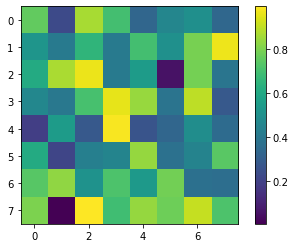

In [79]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)
    
import torch
from matplotlib import pyplot as plt

a = torch.rand(1,3,8,8)
N,C,H,W = a.size()
plt.imshow(a[0,0])
plt.colorbar()
plt.show()

torch.Size([1, 3, 8, 1])
torch.Size([1, 3, 1, 8])


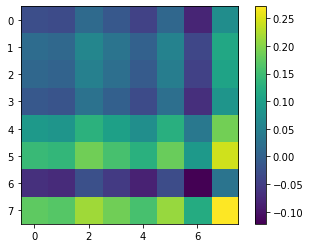

In [80]:
from torch import nn
conv_c = nn.Conv2d(C, 1, 1, bias=False)
conv_h = nn.Conv2d(C, C, (1, W), bias=False, groups=C)
conv_w = nn.Conv2d(C, C, (H, 1), bias=True, groups=C)
act = nn.SELU()
# act = nn.Softmax(dim=2)

x_h = conv_h(a)
x_w = conv_w(a)

print(x_h.shape)
print(x_w.shape)
# print(torch.relu(x_h+x_w).shape)

result = conv_c(act(x_h+x_w)).detach()
# result = torch.softmax(result.view(N,1,-1), dim=2).view(N,1,W,H)
plt.imshow(result[0,0])
plt.colorbar()
plt.show()

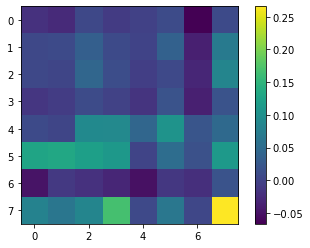

In [81]:
f = torch.mul(result.expand_as(a), a) 
plt.imshow(f[0,1])
plt.colorbar()
plt.show()

# 1st Test

In [102]:
from torch.nn import functional as F
class CoordAttentionBlock(nn.Module):
    def __init__(self, n_channels: int, img_size: tuple) -> None:
        super(CoordAttentionBlock, self).__init__()
        C = n_channels
        H, W = img_size
        
        self.conv_c = nn.Conv2d(C, 1, 1, bias=False)
        # self.conv_h = nn.Conv2d(C, 1, (1, W), bias=False)
        # self.conv_w = nn.Conv2d(C, 1, (H, 1), bias=False)
        self.conv_h = nn.Conv2d(C, C, (1, W), bias=False, groups=C)
        self.conv_w = nn.Conv2d(C, C, (H, 1), bias=True, groups=C)
        # self.act = nn.Softmax(1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        N,C,H,W = x.size()
        x_h = self.conv_h(x)
        x_w = self.conv_w(x)

        c = self.conv_c(torch.sigmoid(x_h+x_w))
        # c = self.conv_c(x_h+torch.sigmoid(x_w))
        # c = torch.relu(x_h+x_w)
        
        a = torch.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        f = torch.mul(a.expand_as(x), x)
        output = f.view(N,C,-1).sum(dim=2)
        
        return c, output

In [103]:
class ConvTestBlock(nn.Module):
    def __init__(self, in_channels, out_channels, img_size: tuple) -> None:
        super(ConvTestBlock, self).__init__()
        self.conv = nn.Sequential(*[
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ])

        self.coordAttBlock = CoordAttentionBlock(out_channels, img_size)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        attention = self.coordAttBlock(x)
        
        return torch.mul(attention.expand_as(x), x)

In [107]:
class Model(nn.Module):
    def __init__(self, ) -> None:
        super(Model, self).__init__()
        self.l1 = nn.Sequential(*[
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ])
        self.l2 = nn.Sequential(*[
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ])
        self.l3 = nn.Sequential(*[
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ])

        self.classifier = nn.Sequential(*[
            nn.Linear(64+128+256,32),
            nn.ReLU(),
            nn.Linear(32,10)
        ])

        img_size = 32
        self.coordAttBlock_l1 = CoordAttentionBlock(64, (int(img_size/2**1), int(img_size/2**1)) )
        self.coordAttBlock_l2 = CoordAttentionBlock(128, (int(img_size/2**2), int(img_size/2**2)) )
        self.coordAttBlock_l3 = CoordAttentionBlock(256, (int(img_size/2**3), int(img_size/2**3)) )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x_l1 = self.l1(x)
        x_l2 = self.l2(x_l1)
        x_l3 = self.l3(x_l2)

        c1, g1 = self.coordAttBlock_l1(x_l1)
        c2, g2 = self.coordAttBlock_l2(x_l2)
        c3, g3 = self.coordAttBlock_l3(x_l3)

        g = torch.cat((g1,g2,g3), dim=1)
        y_hat = self.classifier(g)

        return (y_hat, c1, c2, c3)

In [99]:
class Model(nn.Module):
    def __init__(self, ) -> None:
        super(Model, self).__init__()
        self.l1 = nn.Sequential(*[
            nn.Conv2d(1, 3, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ])
        self.l2 = nn.Sequential(*[
            nn.Conv2d(3, 6, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ])
        self.l3 = nn.Sequential(*[
            nn.Conv2d(6, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ])

        self.classifier = nn.Sequential(*[
            nn.Linear(3+6+8,10)
        ])

        img_size = 32
        self.coordAttBlock_l1 = CoordAttentionBlock(3, (int(img_size/2**1), int(img_size/2**1)) )
        self.coordAttBlock_l2 = CoordAttentionBlock(6, (int(img_size/2**2), int(img_size/2**2)) )
        self.coordAttBlock_l3 = CoordAttentionBlock(8, (int(img_size/2**3), int(img_size/2**3)) )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x_l1 = self.l1(x)
        x_l2 = self.l2(x_l1)
        x_l3 = self.l3(x_l2)

        c1, g1 = self.coordAttBlock_l1(x_l1)
        c2, g2 = self.coordAttBlock_l2(x_l2)
        c3, g3 = self.coordAttBlock_l3(x_l3)

        g = torch.cat((g1,g2,g3), dim=1)
        y_hat = self.classifier(g)

        return (y_hat, c1, c2, c3)

## Dataset

In [108]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize

transform = Compose([Resize(32), ToTensor()])
# train_dataset = MNIST('dataset/', train=True, transform=transform, download=True)
train_dataset = CIFAR10('dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# test_dataset = MNIST('dataset/', train=False, transform=transform, download=True)
test_dataset = CIFAR10('dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

img_size = 32

Files already downloaded and verified
Files already downloaded and verified


In [109]:
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as utils
from AttentionMap.utils import visualize_attention
from tqdm import tqdm

model = Model()
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

tb_writer = SummaryWriter('log/CoordAttention/CIFAR')
running_avg_accuracy = 0
step = 0

# TMP
log_images = True
n_epoch = 15

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        # log scalars
        images_disp = []
        for i, data in enumerate(test_loader, 0):
                images_test, labels_test = data
                images_test, labels_test = images_test.to(device), labels_test.to(device)
                pred_test, c1, c2, c3 = model(images_test)
                predict = torch.argmax(pred_test, 1)
                total += labels_test.size(0)
                correct += torch.eq(predict, labels_test).sum().double().item()
                
        tb_writer.add_scalar('test/accuracy', correct/total, epoch)

        n_rows=4
        n_images = 24
        activation = 'softmax'
        # C1
        scale_factor = 2**1
        vis = visualize_attention(n_rows, images_test[:n_images], c1[:n_images], scale_factor, activation=activation)
        tb_writer.add_image('Attention/C1', vis, epoch)

        # C2
        scale_factor = 2**2
        vis = visualize_attention(n_rows, images_test[:n_images], c2[:n_images], scale_factor, activation=activation)
        tb_writer.add_image('Attention/C2', vis, epoch)

        # C3
        scale_factor = 2**3
        vis = visualize_attention(n_rows, images_test[:n_images], c3[:n_images], scale_factor, activation=activation)
        tb_writer.add_image('Attention/C3', vis, epoch)

    model.train()
    for idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        inputs = inputs.to(device)
        targets = targets.to(device)
        pred, __, __, __ = model(inputs)

        loss = criterion(pred, targets)
        loss.backward()
        optimizer.step()

        if idx % 250 == 0:
            model.eval()
            pred, __, __, __ = model(inputs)
            predict = torch.argmax(pred, 1)
            total = targets.size(0)
            correct = torch.eq(predict, targets).sum().double().item()
            accuracy = correct / total
            running_avg_accuracy = 0.6*running_avg_accuracy + 0.4*accuracy
            tb_writer.add_scalar('train/loss', loss.item(), step)
            tb_writer.add_scalar('train/accuracy', accuracy, step)
            tb_writer.add_scalar('train/running_avg_accuracy', running_avg_accuracy, step)
            step += 1

            epoch_iterator.set_postfix(tls="%.4f" % loss.item())            

100%|██████████| 15/15 [03:10<00:00, 12.69s/epoch, tls=0.4447]


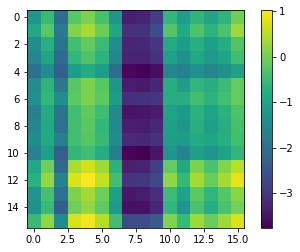

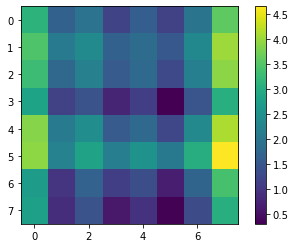

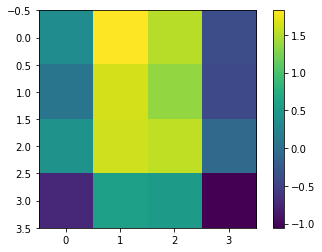

In [113]:
plt.imshow(c1[0,0].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(c2[0,0].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(c3[0,0].detach().cpu())
plt.colorbar()
plt.show()

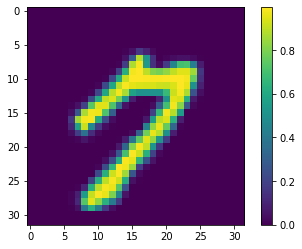

In [114]:
plt.imshow(input[0,0].detach().cpu())
plt.colorbar()
plt.show()